In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import copy
import matplotlib.pyplot as plt

In [2]:
adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Hao_PBMC_GSE164378_raw.h5ad")
adata.shape

(161764, 33538)

In [3]:
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA
L1_AAACCCAAGAAACTCA,Mono,CD14 Mono,CD14 Mono,Batch1,P2,7,L1,G1,7535,217,10823,2915
L1_AAACCCAAGACATACA,CD4 T,CD4 TCM,CD4 TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617
L1_AAACCCACAACTGGTT,CD8 T,CD8 Naive,CD8 Naive,Batch1,P4,2,L1,S,6620,213,5067,1381
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890
L1_AAACCCACAGCATACT,CD8 T,CD8 Naive,CD8 Naive,Batch1,P4,7,L1,G1,6402,215,6505,1621


In [4]:
type(adata.X)

scipy.sparse._csc.csc_matrix

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20)

## Normalization

In [5]:
# Normalization
# each observation (cell) has a total count equal to the median of total counts for observations (cells)
sc.pp.normalize_total(adata, target_sum=None)  # see PreLect performance to see if target_sum is needed
# log1p transformation
sc.pp.log1p(adata)

In [6]:
type(adata.X)

scipy.sparse._csc.csc_matrix

In [5]:
adata.raw = adata

In [7]:
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

In [8]:
type(adata.X)

numpy.ndarray

## UMAP before batch effect correction

In [7]:
sc.tl.pca(adata, svd_solver="arpack")

In [8]:
# neighborhood graph
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


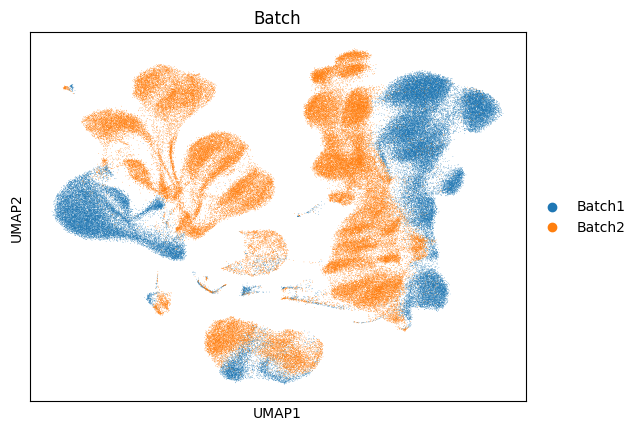

In [9]:
sc.tl.umap(adata)
sc.pl.umap(adata, color='Batch')

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_

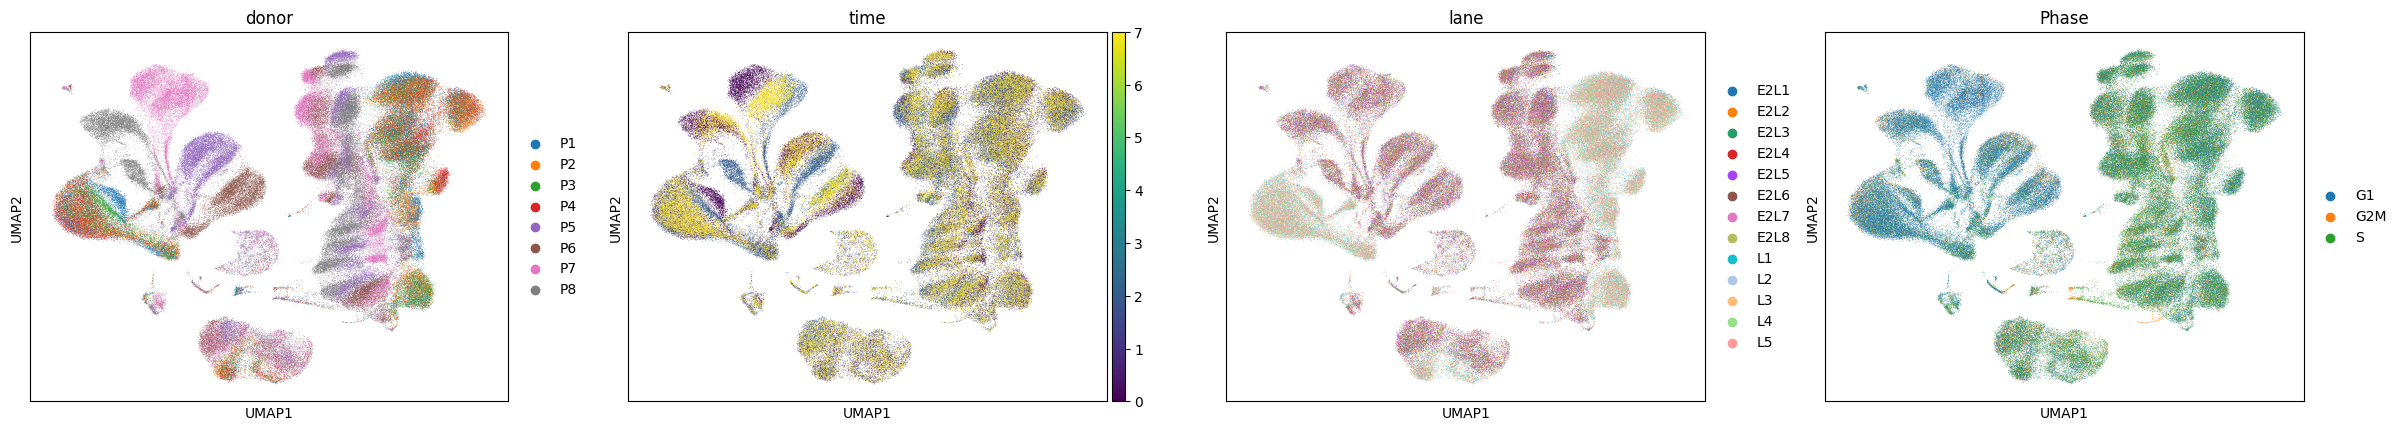

In [10]:
sc.pl.umap(adata, color=['donor', 'time', 'lane', 'Phase'])

## Batch effect correction with Harmony

In [11]:
import scanpy.external as sce

sce.pp.harmony_integrate(adata, key='Batch')

2024-04-04 17:26:54,188 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-04-04 17:28:02,443 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-04-04 17:28:02,953 - harmonypy - INFO - Iteration 1 of 10
2024-04-04 17:28:44,655 - harmonypy - INFO - Iteration 2 of 10
2024-04-04 17:29:26,325 - harmonypy - INFO - Iteration 3 of 10
2024-04-04 17:30:08,007 - harmonypy - INFO - Converged after 3 iterations


In [12]:
# Harmony adds a new table in adata.obsm containing the adjusted PC’s.
'X_pca_harmony' in adata.obsm

True

In [13]:
# Use the batch-corrected PCs for calculating the neighbors
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_pca_harmony')

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


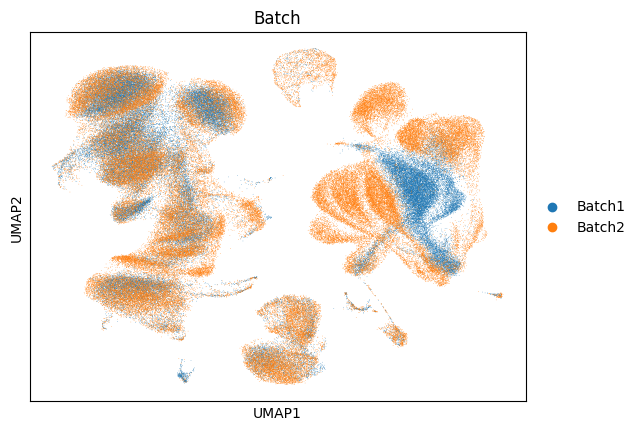

In [14]:
sc.tl.umap(adata)
sc.pl.umap(adata, color='Batch')

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_

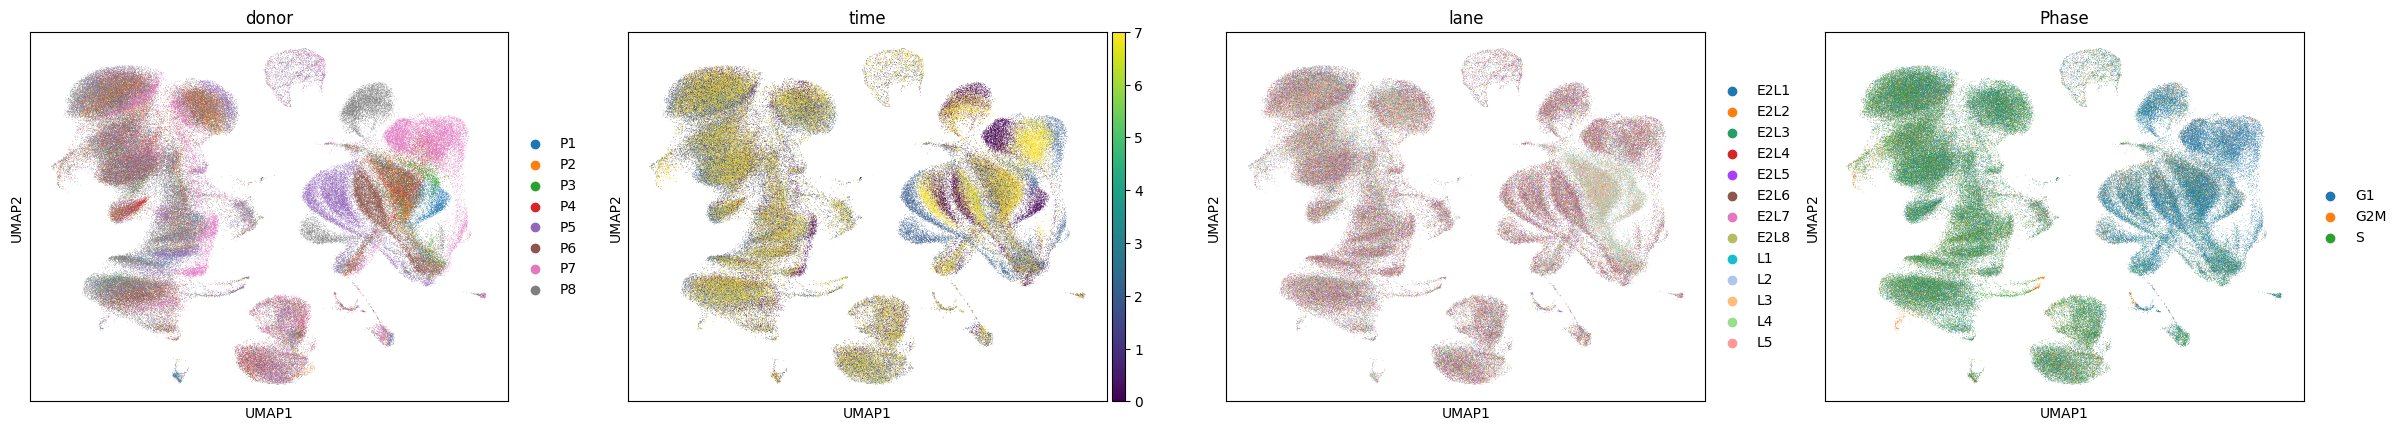

In [15]:
sc.pl.umap(adata, color=['donor', 'time', 'lane', 'Phase'])

## Leiden

In [16]:
sc.tl.leiden(adata, resolution=0.9)

In [17]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)
sc.tl.umap(adata, init_pos='paga')


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_

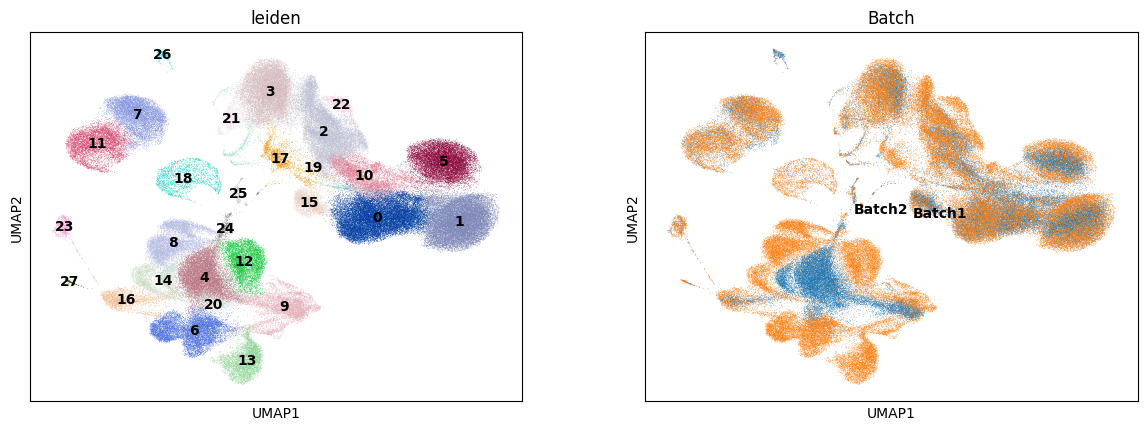

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_

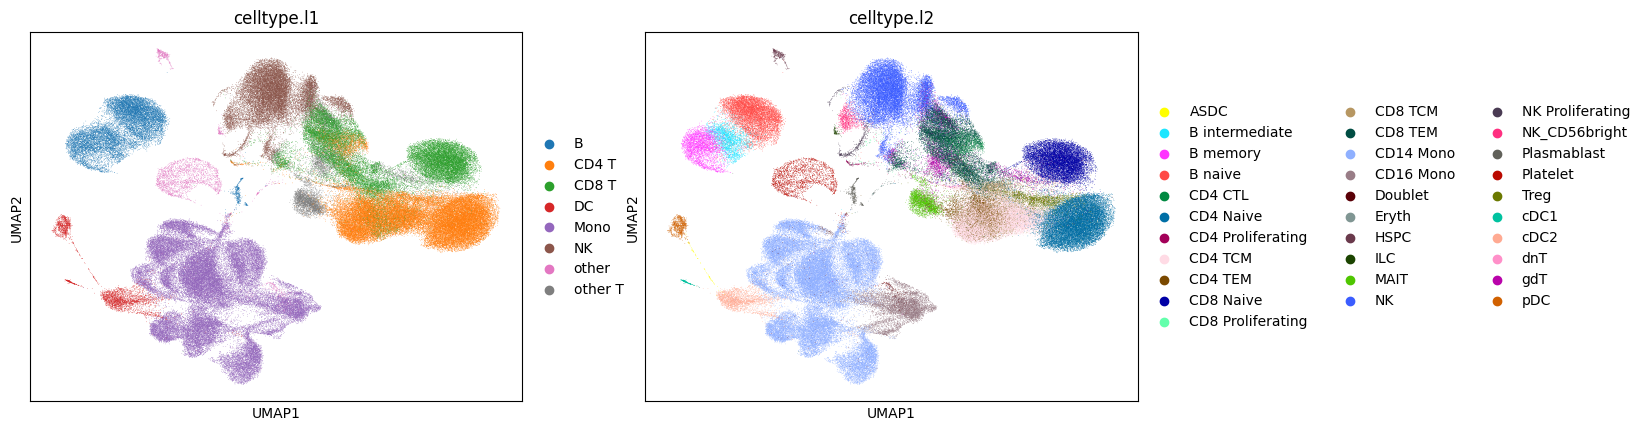

In [18]:
sc.pl.umap(adata, color=['leiden', 'Batch'], legend_loc="on data")
sc.pl.umap(adata, color=['celltype.l1', 'celltype.l2'], legend_loc="right margin")

In [19]:
adata.obs['leiden'].unique()

['4', '0', '5', '3', '10', ..., '22', '13', '12', '27', '8']
Length: 28
Categories (28, object): ['0', '1', '2', '3', ..., '24', '25', '26', '27']

In [20]:
adata.shape

(161764, 33538)

## Write Harmony-corrected to h5ad

In [21]:
output_h5ad_path = r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Batch_corrected\Hao_PBMC_scaled_Harmony.h5ad"
adata.write(filename=output_h5ad_path)